#Footy tipping!

We're going to construct features.

Deliberately keeping the number of features low.

In [2]:
# Render our plots inline
%matplotlib inline
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make the graphs a bit prettier
pd.set_option('display.mpl_style', 'default') 
plt.rcParams['figure.figsize'] = (15, 5)
# Limit the size of the dataframe html output in the ipython notebook.
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)
# Loading the data
teams = pd.read_csv('data/teams.csv')
seasons = pd.read_csv('data/seasons.csv')
unplayed = pd.read_csv('data/unplayed.csv')

So the variables we want are:
+ Team id
+ Last year's percentage for both teams
+ Last year's points for both teams

In [3]:
# Simplifying the data set
df_train = seasons[["mid", 'season', 'round', 'tid1_loc', 
                    'tid1', 'tid2', 'win_tid', 'h_tid', 'h_score', 
                    'a_tid', 'a_score', 'margin' ]]

In [5]:
sLength = len(df_train['mid'])
df_train.loc[:, 'tid1_score'] = 0 
df_train.loc[:, 'tid2_score'] = 0 

In [6]:
home_is_tid1 = (df_train['h_tid'] == df_train['tid1'])
away_is_tid1 = (df_train['a_tid'] == df_train['tid1'])
df_train.ix[home_is_tid1,'tid1_score'] = df_train['h_score']
df_train.ix[away_is_tid1,'tid1_score'] = df_train['a_score']
df_train.ix[away_is_tid1,'tid2_score'] = df_train['h_score']
df_train.ix[home_is_tid1,'tid2_score'] = df_train['a_score']

In [7]:
# Calculating last year's percentage
# scores for
tid1_scores = df_train.groupby(['season', 'tid1']).sum()['tid1_score']
tid2_scores = df_train.groupby(['season', 'tid2']).sum()['tid2_score']
scores_for = pd.concat([tid1_scores, tid2_scores], axis=1)
scores_for['scores_for'] = 0
scores_for.scores_for = scores_for.tid1_score.fillna(0) + scores_for.tid2_score.fillna(0)
#scores against
tid1_game_tid2_opponent_score = df_train.groupby(['season', 'tid1']).sum()['tid2_score']
tid2_game_tid1_opponent_score = df_train.groupby(['season', 'tid2']).sum()['tid1_score']
scores_against = pd.concat([tid1_game_tid2_opponent_score, tid2_game_tid1_opponent_score], axis=1)
scores_against['scores_against'] = 0
scores_against.scores_against = scores_against.tid1_score.fillna(0) + scores_against.tid2_score.fillna(0)
current_year = pd.concat([scores_for, scores_against], axis=1)
current_year = current_year[['scores_for', 'scores_against']]
current_year['percentage'] = current_year['scores_for'] / current_year['scores_against']
current_year = current_year[['percentage']]

In [8]:
df_train.loc[:, 'tid1_last_season_percentage'] = 0
df_train.loc[:, 'tid2_last_season_percentage'] = 0
teams_list = pd.unique(teams['tid'].ravel())
teams_list_pre_2011 = np.delete(teams_list, [7,8])
teams_list_pre_2012 = np.delete(teams_list, [8])
seasons_list = pd.unique(df_train.season.ravel())
base_year = 2001

for year in range(base_year, 2015+1):
    for team in teams_list_pre_2011:
        df_train.loc[(df_train['season']==year) & (df_train['tid1']==team), 
                     'tid1_last_season_percentage'] = current_year.loc[year-1, team][0]            
        df_train.loc[(df_train['season']==year) & (df_train['tid2']==team), 
                     'tid2_last_season_percentage'] = current_year.loc[year-1, team][0]            

In [9]:
# Bloody Gold Coast
# Give them their first year's percentage as the lagged percentage
df_train.loc[(df_train['season']==2011) & (df_train['tid1']==108), 
             'tid1_last_season_percentage'] = current_year.loc[2011, 108][0]            
df_train.loc[(df_train['season']==2011) & (df_train['tid2']==108), 
             'tid2_last_season_percentage'] = current_year.loc[2011, 108][0]
for year in range(2012, 2015+1):
    df_train.loc[(df_train['season']==year) & (df_train['tid1']==108), 
                 'tid1_last_season_percentage'] = current_year.loc[year-1, 108][0]            
    df_train.loc[(df_train['season']==year) & (df_train['tid2']==108), 
                 'tid2_last_season_percentage'] = current_year.loc[year-1, 108][0] 

In [10]:
# Bloody GWS
# Give them their first year's percentage as the lagged percentage
df_train.loc[(df_train['season']==2012) & (df_train['tid1']==109), 
             'tid1_last_season_percentage'] = current_year.loc[2012, 109][0]
df_train.loc[(df_train['season']==2012) & (df_train['tid2']==109), 
             'tid2_last_season_percentage'] = current_year.loc[2012, 109][0]            
for year in range(2013, 2015+1):
    df_train.loc[(df_train['season']==year) & (df_train['tid1']==109), 
                 'tid1_last_season_percentage'] = current_year.loc[year-1, 109][0]             
    df_train.loc[(df_train['season']==year) & (df_train['tid2']==109), 
                 'tid2_last_season_percentage'] = current_year.loc[year-1, 109][0]

### Calculating the win ratio for the year to date

win ratio = $\frac{\# wins + 0.5\cdot\#draws}{\#games}$

Base year

In [11]:
df_train_0 = df_train

In [12]:
# Collecting premiership points. Ignoring draws.
df_train_0.loc[:,'tid1_points'] = 0
df_train_0.loc[(df_train_0['tid1']==df_train_0['win_tid']), 'tid1_points'] = 1
df_train_0.loc[:,'tid2_points'] = 0
df_train_0.loc[(df_train_0['tid2']==df_train_0['win_tid']), 'tid2_points'] = 1
df_train.loc[(df_train['margin']== 0), 'tid1_points'] = 0.5
df_train.loc[(df_train['margin']== 0), 'tid2_points'] = 0.5
tid1_points = df_train.groupby(['season', 'tid1']).sum()['tid1_points']
tid2_points = df_train.groupby(['season', 'tid2']).sum()['tid2_points']
tid_points = pd.concat([tid1_points, tid2_points], axis=1)
tid_points['tid_points'] = 0
tid_points.tid_points = tid_points.tid1_points.fillna(0) + tid_points.tid2_points.fillna(0)
# dividing by total amount of games
tid_points['total_points'] = (22.0)
tid_points['win_ratio'] = tid_points.tid_points / tid_points.total_points
tid_points = tid_points[['win_ratio']]

In [13]:
df_train.loc[:, 'tid1_last_season_win_ratio'] = 0
df_train.loc[:, 'tid2_last_season_win_ratio'] = 0
teams_list = pd.unique(teams['tid'].ravel())
teams_list_pre_2011 = np.delete(teams_list, [7,8])
teams_list_pre_2012 = np.delete(teams_list, [8])
seasons_list = pd.unique(df_train.season.ravel())

for year in range(base_year, 2015+1):
    for team in teams_list_pre_2011:
        df_train.loc[(df_train['season']==year) & (df_train['tid1']==team), 
                     'tid1_last_season_win_ratio'] = tid_points.loc[year-1, team][0]            
        df_train.loc[(df_train['season']==year) & (df_train['tid2']==team), 
                     'tid2_last_season_win_ratio'] = tid_points.loc[year-1, team][0]            

In [14]:
# Bloody Gold Coast
# Give them their first year's percentage as the lagged percentage
df_train.loc[(df_train['season']==2011) & (df_train['tid1']==108), 
             'tid1_last_season_win_ratio'] = tid_points.loc[2011, 108][0]            
df_train.loc[(df_train['season']==2011) & (df_train['tid2']==108), 
             'tid2_last_season_win_ratio'] = tid_points.loc[2011, 108][0]
for year in range(2012, 2015+1):
    df_train.loc[(df_train['season']==year) & (df_train['tid1']==108), 
                 'tid1_last_season_win_ratio'] = tid_points.loc[year-1, 108][0]            
    df_train.loc[(df_train['season']==year) & (df_train['tid2']==108), 
                 'tid2_last_season_win_ratio'] = tid_points.loc[year-1, 108][0] 

In [15]:
# Bloody GWS
# Give them their first year's percentage as the lagged percentage
df_train.loc[(df_train['season']==2012) & (df_train['tid1']==109), 
             'tid1_last_season_win_ratio'] = tid_points.loc[2012, 109][0]
df_train.loc[(df_train['season']==2012) & (df_train['tid2']==109), 
             'tid2_last_season_win_ratio'] = tid_points.loc[2012, 109][0]            
for year in range(2013, 2015+1):
    df_train.loc[(df_train['season']==year) & (df_train['tid1']==109), 
                 'tid1_last_season_win_ratio'] = tid_points.loc[year-1, 109][0]             
    df_train.loc[(df_train['season']==year) & (df_train['tid2']==109), 
                 'tid2_last_season_win_ratio'] = tid_points.loc[year-1, 109][0]

A column indicating whether *tid1* won

In [16]:
df_train.loc[:, 'prob'] = 0
df_train.loc[(df_train['win_tid'] == df_train['tid1']), 'prob'] = 1         


Generating team dummies, and home or away for tid1

In [17]:
df_train = pd.get_dummies(df_train, columns=["tid1", "tid2", "tid1_loc"])

Extracting the round from the data

In [18]:
df_train["round"] = df_train["round"].str.slice(1).astype(int)

*Testing the data.*

- North's previous year's percentage was 83.37.
- North's previous year's win ratio was 34 percent

      tid2_112  tid2_last_season_percentage  tid2_last_season_win_ratio
1935         1                     0.833747                    0.340909


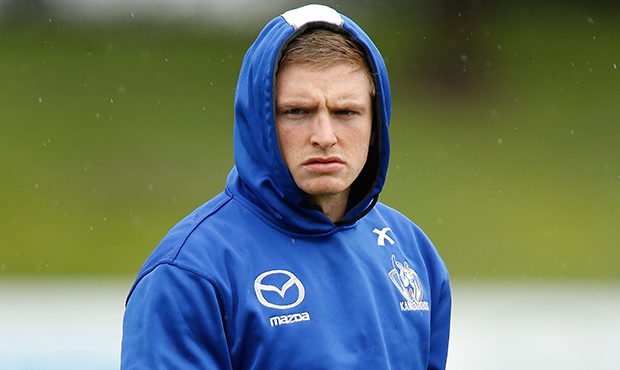

In [19]:
df_pruf = df_train
df_pruf = df_pruf[(df_pruf['season']==2010) & (df_pruf['round']==22)]
print df_pruf[['tid2_112', 'tid2_last_season_percentage', 'tid2_last_season_win_ratio']][7:]
Image(filename='jz.jpg')

Developing the training, cross validation and test data

In [20]:
# Constructing a training, validation and hold out sets
df_cv = df_train[(df_train["season"] >= 2013) * 
                df_train["season"] <= 2014].reset_index(drop=True)
df_test = df_train[df_train["season"] == 2015].reset_index(drop=True)
df_train = df_train[(df_train["season"] >= base_year) & 
                   df_train["season"] <= 2012].reset_index(drop=True)

In [21]:
df_train.to_pickle('afl_train_full_season.pkl')
df_cv.to_pickle('afl_cval_full_season.pkl')
df_test.to_pickle('afl_test_full_season.pkl')